# Sequential Action Control Example for cartpole 

## Import necessary package

In [1]:
import mujoco
import mujoco.viewer
import numpy as np

import jax
import jax.numpy as jnp
from jax import jacfwd, grad, vmap, jit
import time
import matplotlib.pyplot as plt
import mediapy as media
from tqdm import tqdm

## Define the necessary function for the rollout  

### Then we need to define additional functions 

**step_forward(x_0, u)**. This function assumes non-linear dynamics $f$ and the next state is $x_{t+1} = f(x_t, u_t)$


**get_dfdx_dfdu(x_0, u)**. Find continuous time derivative of the dynamics $\frac{\partial f}{\partial x}$ and $\frac{\partial f}{\partial u}$ From discrete dynamics to continuous dynamics:
$$
    \dot{x} = f_c(x,u) =  A_cx + B_cu
$$
$$
    x_{t+1} = x_t + \dot{x} * dt = x_t + \left[ A_cx_t + B_cu_t \right] dt
$$
$$
    x_{t+1} = (I + A_cdt)x_t + B_cu_tdt 
$$
So we can get relationship between the discrete dynamics and continuous dynamics $A_d = (I + A_cdt)$ and $B_d = B_c dt$

**get_f(x_0, u)**. Get continuous version of the dynamics $\dot{x} = f_c(x,u)$
$$
    x_{t+1} = x_t + f_c(x_t,u_t)dt 
$$

In [2]:
def step_forward(x_0:np.array, u:np.array):
    # make sure the shape of control is the dimension of the torque
    assert (u.shape[0] ==  mj_model.nu)
    assert (x_0.shape[0] == mj_model.nq + mj_model.nv)
    state = get_state(mj_model, mj_data)
    ctrl = mj_data.ctrl
    
    mj_data.qpos = x_0[:mj_model.nq]
    mj_data.qvel = x_0[mj_model.nq:]
    mj_data.act = []
    mj_data.ctrl = u.reshape(mj_model.nu,)
    mujoco.mj_step(mj_model, mj_data)
    
    next_state = np.concatenate((mj_data.qpos, mj_data.qvel), axis=0)
    mujoco.mj_setState(mj_model, mj_data, state, mujoco.mjtState.mjSTATE_FULLPHYSICS)
    mujoco.mj_setState(mj_model, mj_data, ctrl, mujoco.mjtState.mjSTATE_CTRL)
    
    return next_state, x_0

def get_state(model, data):
    nstate = mujoco.mj_stateSize(model, mujoco.mjtState.mjSTATE_FULLPHYSICS)
    state = np.empty(nstate)
    mujoco.mj_getState(model, data, state, mujoco.mjtState.mjSTATE_FULLPHYSICS)
    return state.reshape((nstate, 1))

def get_dfdx_dfdu(x: np.array, u: np.array):
    # Find continuous time derivative of the dynamics in MuJoCo
    # we might want to decrease the dt here to get better finite differencing
    assert (x.shape[0] == mj_model.nq + mj_model.nv)

    mujoco.mj_resetData(mj_model, mj_data)
    mj_data.qpos = x[:mj_model.nq]
    mj_data.qvel = x[mj_model.nq:]
    mj_data.ctrl = u.reshape(mj_model.nu, )

    dfdx_mujoco = np.zeros((2 * mj_model.nv, 2 * mj_model.nv))
    dfdu_mujoco = np.zeros((2 * mj_model.nv, mj_model.nu))
    epsilon = 1e-6
    flg_centered = True

    mj_model.opt.timestep = 1e-5
    mujoco.mjd_transitionFD(mj_model, mj_data, epsilon, flg_centered, dfdx_mujoco, dfdu_mujoco, None, None)
    
    conti_A = (dfdx_mujoco - np.eye(dfdx_mujoco.shape[0])) / mj_model.opt.timestep
    conti_B = dfdu_mujoco / mj_model.opt.timestep

    mj_model.opt.timestep = dt
    return  conti_A, conti_B 

def get_f(x,u):
    mj_model.opt.timestep = 1e-5
    # get continuous version of the dynamics using finite difference
    x_next = step_forward(x,u)[0]
    f_c = (x_next - x) / mj_model.opt.timestep
    mj_model.opt.timestep = dt
    return f_c

## Define terminal cost and step cost. Get its gradient

In [3]:
def term_cost(x):
    q,qdot = jnp.split(x,2)
    return -1.0*jnp.cos(q[1])  + 0.01* qdot@qdot + 0.1* q[0]**2

In [4]:
def running_cost(x, u):
    q,qdot = jnp.split(x,2)
    ell = -10.0*jnp.cos(q[1])  + 0.00001*jnp.sum(u**2) + 0.01 * qdot@qdot + 0.1 *q[0]**2
    return ell

## Define Scan function where is the replicate of jax scan 

Scan function can be used to perform forward rollout and backward rollout 

In [5]:
def scan(f, init, xs, length=None):
  # replacement of jax scan function to make it compatible with
  # the mujoco which is not using jax
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, jnp.stack(ys)

### Test case for scan function 

In [6]:
# key = jax.random.PRNGKey(758493)  # Random seed is explicit in JAX

# xml_path = "./cartpole.xml"
# mj_model = mujoco.MjModel.from_xml_path(xml_path)
# mj_data = mujoco.MjData(mj_model)
# x_0 = np.array([0, 3.1, 0., 0.])
# u = (jax.random.uniform(key, shape=(20, 1))- 0.5) *2 

# # test scan 
# x_term, X = forward_sim(x_0, u)

# # ground truth 
# X_t = [x_0]
# for i in u:
#     x, _ = step_forward(X_t[-1], i)
#     X_t.append(x)
# X_t = jnp.array(X_t)
# print(jnp.array_equal(X, X_t[:-1]))
# print(jnp.array_equal(x_term, X_t[-1]))


## Get backward simulation given a finite horizon 

We can backpropogate the co-state from $t_f$ to $t_0$
$$
\dot{\rho} = -\nabla l_1(x) - D_x f(x, u_{def})^T\rho
$$

In discrete time, we will have
$$
\rho_{t-1} = \rho_{t} - \dot{\rho}_t * dt
$$

In [7]:
def drhodt(rho, v, u):
    dfdx_mujoco, dfdu_mujoco = get_dfdx_dfdu(v, u)
    return  - Drunning_cost(v,u) - dfdx_mujoco.T @ rho

def F_backward(rho, v):
    x, u = v[:mj_model.nq + mj_model.nv], v[mj_model.nq + mj_model.nv:]
    assert (x.shape[0] == mj_model.nq + mj_model.nv)
    assert (u.shape[0] == mj_model.nu)
    rhodot = drhodt(rho, x, u)
    rhop = rho - dt * rhodot
    return rhop, rhop

In [8]:
# get the gradient using jax grad 
Dterm_cost = grad(term_cost)
Drunning_cost = grad(running_cost)
forward_sim = lambda x0, u: scan(step_forward, x0, u)
backward_sim = lambda rho0, v, u: scan(F_backward, rho0, jnp.concatenate([v[::-1], u[::-1]], axis=1))

### Find Optimal control 

Here we can find the optimal control by minimizing the auxiliary objective function $l_2$ 

$$l_2 (\tau, u_2(\tau)) = \frac{dJ}{d\lambda}(\tau, u_2(\tau)) + || u_2(\tau) ||_R^2 $$
where $\frac{dJ}{d\lambda} $ is the mode insertion gradient
$$ \frac{dJ}{d\lambda}(\tau, u_2(\tau)) = \rho^T(\tau) \cdot \left[ f(x\left(\tau), u^\star(\tau)\right) - f(x(\tau), u_{def}(\tau)) \right] $$
Then we find the optimal control:
$$
    argmin_{u^\star(\tau)} l_2 
$$
$$
  argmin_{u^\star(\tau)}  \rho^T(\tau) \cdot \left[ f(x\left(\tau), u^\star(\tau)\right) - f(x(\tau), u_{def}(\tau)) \right] + || u_2(\tau) ||_R^2
$$
Take the gradient of the objective function:
$$
    \frac{\partial l_2}{\partial u^\star(\tau)} = Ru^\star + \rho^T \frac{\partial f}{\partial u^\star(\tau)}(x(\tau), u^\star)
$$
We use gradient descent to find the optimal control across the time horizon 
$$
    u^\star = u^\star - \alpha * \frac{\partial l_2}{\partial u^\star(\tau)}
$$
where $\alpha$ is the learning rate

In [9]:
def l2(x, u1, u2,rho):
    return 1/2*R*(u2-u1)**2 + rho @ (get_f(x,u2) - get_f(x, u1))

def Dl2Du(x, u1, u2 ,rho):
    # u2 is u_star and u1 is udef
    dfdx_mujoco, dfdu_mujoco = get_dfdx_dfdu(x, u2)
    return R*(u2-u1) + rho @ dfdu_mujoco

def u_tau(x, rho, udef):
    # here we use gradient descen to find the best actions
    # set intial guess of the control, u_star = u_def
    u_star = np.array([0.]) # np.array([-0.1]) 
    u_stars = [u_star]
    # use gradient descent to update the optimal control 
    error = 1 
    idx = 0 
    # print("before l2 ", l2(x, udef, u_star,rho))
    while error > 0.001:
        u_star = u_star - 0.1 * Dl2Du(x, udef, u_star, rho)
        idx += 1
        error = np.linalg.norm(u_star - u_stars[-1])
        u_stars.append(u_star)
        if idx >= 300:
            break
    # print("after l2 ", l2(x, udef, u_star,rho))
    # dfdx_mujoco, dfdu_mujoco = get_dfdx_dfdu(x, udef)
    # np.clip((-rho @ dfdu_mujoco + udef), -1., 1.)
    return np.clip(u_star, -1. , 1.)

Find Optimal Time to Act

In [10]:
def dJdlam(rho, x, u2, u1):
    assert(x.shape[0] == mj_model.nq + mj_model.nv)
    assert(rho.shape[0] == 2*mj_model.nv)
    temp = get_f(x,u2) - get_f(x, u1)
    return rho.T @ temp

## Main code for SAC 

In [11]:
def SAC(x0, U1):
    U1 = U1.at[:-1, :].set(U1[1:, :])
    U1 = U1.at[-1, :].set(U1[-1, :])
    
    xf, X = forward_sim(x0, U1)
    rhof = np.array(Dterm_cost(xf))
    # Here rhof is 2*mj_model.nv
    rho0, rho = backward_sim(rhof, X, U1)

    U_tau = np.stack(list(map(lambda x_map, rho_map, u_map: u_tau(x_map, rho_map, u_map), X, rho[::-1], U1)))

    tau_idx = np.argmin(np.stack(list(
        map(lambda rho_map, x_map, u_2_map, u1_map: dJdlam(rho_map, x_map, u_2_map, u1_map), rho[::-1], X, U_tau,
            U1)))) 
    
    u_star = U_tau[tau_idx]
    # line search
    J_best = np.inf
    lam_idx_best = 0

    for lam_idx in range(0, T - tau_idx + 1):
        _U2 = U1.at[tau_idx:tau_idx + lam_idx].set(u_star)
        _xf, _X = forward_sim(x0, _U2)
        J_line = np.mean(np.stack(list(map(lambda X, U: running_cost(X, U), _X, _U2))))      
        if J_line < J_best:
            J_best = J_line
            lam_idx_best = lam_idx
    # print("J line search results: ", J_line, lam_idx, J_best, lam_idx_best)
    return U1.at[tau_idx:tau_idx + lam_idx_best].set(u_star)

## Main Simulation 

In [12]:
# Make new camera, set distance.
dt = 0.01
ths = np.array([0.03]) # np.arange(0.4, 1.5, 0.1)
tf = 2
Rs =  np.array([0.001])# [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
xml_path = "./cartpole.xml"
mj_model = mujoco.MjModel.from_xml_path(xml_path)
mj_data = mujoco.MjData(mj_model)
mj_model.opt.timestep = dt

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(mj_model, camera)
camera.distance = 4.0

# Enable contact force visualisation.
scene_option = mujoco.MjvOption()

# New renderer instance with higher resolution.
renderer = mujoco.Renderer(mj_model, width=1280, height=720)

In [13]:
if __name__ == "__main__":
    for th in tqdm(ths):
        for R in Rs:
            T = int(th / dt)
            Framerates = 30
            x_0 = np.array([0, 0.2, 0., 0.])
            # set inintial state
            ctrl = jnp.zeros((int(th / dt), 1))
            ctrl = SAC(x_0, ctrl)
        
            log = []
            u_log = []
            cost_log = []
        
            # print("nv is ", mj_model.nv)
            # print("nu is ", mj_model.nu)
            # print("nq is ", mj_model.nq)
            frames = []
            time_now = 0
            for t in range(int(tf/dt)):
                step_start = time.time()
                time_sac = time.time()
                log.append(np.array(x_0))
                ctrl = SAC(x_0, ctrl) # jnp.array([0])
                u_log.append(np.array(ctrl[0]))
                # print("one iteration for sac is ", time.time() - time_sac)
                # print("ctrl is ", ctrl[0])
                x_0 = step_forward(x_0, ctrl[0])[0]
                time_now += dt
                if len(frames) < time_now * Framerates:
                    renderer.update_scene(mj_data, camera, scene_option)
                    pixels = renderer.render()
                    frames.append(pixels)

            z = np.stack(log)
            v = np.stack(u_log)
            plt.plot(z)
            plt.stem(v, 'k')
            plt.title("Prediction Horizon :{}, R: {}".format(th, R))
            plt.legend(['position','angle','velocity','angular velocity','ctrl'])
            plt.savefig("./figs/cartpole_th_%s_R_%s.png"%(str(th)[:3].replace(".", "_"), str(R).replace(".", "_"))) 
            plt.close()
            media.write_video('./videos/cartpole_th_%s_R_%s.mp4'%(str(th)[:3].replace(".", "_"), str(R).replace(".", "_")), frames, fps=Framerates)




100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.29s/it]


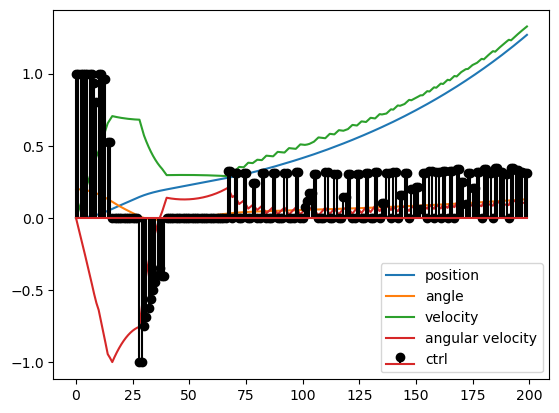

In [14]:
z = np.stack(log)
v = np.stack(u_log)
plt.plot(z)
plt.stem(v, 'k')
plt.legend(['position','angle','velocity','angular velocity','ctrl'])
plt.savefig("cartpole.png") 
plt.show()

In [15]:
media.write_video('cartpole.mp4', frames, fps=Framerates)
media.show_video(media.read_video('cartpole.mp4'), fps=Framerates) # , fps=FRAMERATE